# Feature Engineering

In [101]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import os
import matplotlib.dates as mdates
import math
import warnings
warnings.filterwarnings('ignore')

In [102]:
df_clean = pd.read_csv("CleanData.csv")
df_clean

,Posted Time,Street Name,Ward Name,District Name,Price per m2
0,01/01/2025,Bầu Trảng,Phường Thanh Khê Tây,Quận Thanh Khê,32.80702
1,01/01/2025,Diệp Minh Châu,Phường Hòa Xuân,Quận Cẩm Lệ,38.90000
2,01/01/2025,Dự án Golden Hill,Phường Hòa Hiệp Nam,Quận Liên Chiểu,26.40000
3,01/01/2025,Hòa Hải,Phường Hoà Hải,Quận Ngũ Hành Sơn,38.88889
4,01/01/2025,Hòa Quý,Phường Hoà Quý,Quận Ngũ Hành Sơn,56.50000
...,...,...,...,...,...
10834,31/12/2024,Đường Tôn Đản,Phường Hòa Thọ Tây,Quận Cẩm Lệ,26.50000
10835,31/12/2024,Đường Tú Quỳ,Phường Hòa Minh,Quận Liên Chiểu,31.70000
10836,31/12/2024,Đường số 5,Phường Hòa Hiệp Nam,Quận Liên Chiểu,27.20000
10837,31/12/2024,Đường Đà Sơn,Phường Hòa Khánh Nam,Quận Liên Chiểu,26.58763


In [103]:
def plot_avg_price_by_date(data, date_col="Posted Time", price_col="Price per m2"):
    """
    Plots the average price per day from the provided DataFrame.

    Parameters:
    - data (DataFrame): The DataFrame containing date and price data.
    - date_col (str): The name of the column containing the date information.
    - price_col (str): The name of the column containing the price information.
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(data[date_col], data[price_col], marker='o', linestyle='-')
    plt.title("Average Price per Day (Days with no data = 0)")
    plt.xlabel("Posted Time")
    plt.ylabel("Average Price (Price per m2)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Evaluate the distribution of data

In [104]:
# Chuyển "Posted Time" sang datetime
df_clean["Posted Time"] = pd.to_datetime(df_clean["Posted Time"], dayfirst=True)

# Bước 1: Trung bình giá nếu cùng "Street Name", "Ward Name", "Posted Time"
avg_price_df = (
    df_clean.groupby(["Street Name", "Ward Name", "Posted Time"])["Price per m2"]
    .mean()
    .reset_index()
)

# Bước 2: Tính thống kê cho mỗi vị trí
location_stats = (
    avg_price_df.groupby(["Street Name", "Ward Name"])["Posted Time"]
    .agg(
        Unique_Days="nunique",
        First_Posted="min",
        Last_Posted="max",
        Most_Recent="max"  # cũng là Last_Posted, giữ lại cho rõ
    )
    .reset_index()
)

# Tính số ngày giữa lần đầu và cuối
location_stats["Duration (days)"] = (location_stats["Last_Posted"] - location_stats["First_Posted"]).dt.days

# Hiển thị thống kê
print("Thống kê vị trí (trung bình theo từng ngày):")
print(location_stats.head(10))

# Top 10 vị trí xuất hiện nhiều ngày nhất
print("\nTop 10 vị trí xuất hiện nhiều ngày nhất:")
print(location_stats.sort_values("Unique_Days", ascending=False).head(10))

# Top 10 vị trí có thời gian xuất hiện lâu nhất
print("\nTop 10 vị trí có khoảng thời gian xuất hiện dài nhất:")
print(location_stats.sort_values("Duration (days)", ascending=False).head(10))


Thống kê vị trí (trung bình theo từng ngày):
       Street Name              Ward Name  Unique_Days First_Posted  \
0   An Dương Vương           Phường Mỹ An            1   2024-12-27   
1                .            Xã Hòa Liên            1   2024-12-16   
2        01 Hà Khê  Phường Thanh Khê Đông            1   2025-02-07   
3            10,5m         Phường Hoà Hải            1   2025-01-09   
4            10.5m         Phường Khuê Mỹ            1   2025-03-06   
5     1006 Tôn Đản     Phường Hòa Thọ Tây            2   2025-02-22   
6             10m5       Phường Thọ Quang            1   2025-04-04   
7      129 Vũ Lăng        Phường Hòa Phát            1   2024-12-14   
8        142 Âu cơ   Phường Hòa Khánh Bắc            2   2025-03-16   
9               1A            Xã Hòa Châu            3   2025-02-06   

  Last_Posted Most_Recent  Duration (days)  
0  2024-12-27  2024-12-27                0  
1  2024-12-16  2024-12-16                0  
2  2025-02-07  2025-02-07             

In [105]:
# Đảm bảo cột Posted Time ở dạng datetime
df_clean["Posted Time"] = pd.to_datetime(df_clean["Posted Time"], dayfirst=True)

# Bước 1: Trung bình giá theo "Ward Name" và "Posted Time" (loại bỏ Street Name)
avg_price_ward = (
    df_clean.groupby(["Ward Name", "Posted Time"])["Price per m2"]
    .mean()
    .reset_index()
)

# Bước 2: Tính thống kê theo từng phường
ward_stats = (
    avg_price_ward.groupby("Ward Name")["Posted Time"]
    .agg(
        Unique_Days="nunique",
        First_Posted="min",
        Last_Posted="max",
        Most_Recent="max"
    )
    .reset_index()
)

# Tính số ngày giữa lần đầu và cuối
ward_stats["Duration (days)"] = (ward_stats["Last_Posted"] - ward_stats["First_Posted"]).dt.days

# Bước 3: Thêm giá trung bình tại từng phường
avg_price_each_ward = (
    avg_price_ward.groupby("Ward Name")["Price per m2"]
    .mean()
    .reset_index(name="Avg Price")
)

# Gộp thông tin giá với thống kê thời gian
ward_stats = pd.merge(ward_stats, avg_price_each_ward, on="Ward Name")

# Hiển thị kết quả
print("Thống kê theo phường:")
print(ward_stats.head(10))

print("\nTop 10 phường xuất hiện nhiều ngày nhất:")
print(ward_stats.sort_values("Unique_Days", ascending=False).head(10))

print("\nTop 10 phường có thời gian xuất hiện lâu nhất:")
print(ward_stats.sort_values("Duration (days)", ascending=False).head(10))

print("\nTop 10 phường có giá trung bình cao nhất:")
print(ward_stats.sort_values("Avg Price", ascending=False).head(10))


Thống kê theo phường:
              Ward Name  Unique_Days First_Posted Last_Posted Most_Recent  \
0     Phường An Hải Bắc           85   2024-12-25  2025-04-08  2025-04-08   
1         Phường An Khê           55   2024-12-28  2025-04-08  2025-04-08   
2     Phường Bình Thuận           29   2024-08-08  2025-04-05  2025-04-05   
3     Phường Chính Gián           36   2024-12-17  2025-04-04  2025-04-04   
4        Phường Hoà Hải          120   2024-08-26  2025-04-08  2025-04-08   
5        Phường Hoà Quý          121   2024-08-17  2025-04-08  2025-04-08   
6         Phường Hòa An           91   2024-10-04  2025-04-08  2025-04-08   
7  Phường Hòa Cường Bắc           68   2024-12-18  2025-04-08  2025-04-08   
8  Phường Hòa Cường Nam           60   2024-10-24  2025-04-08  2025-04-08   
9   Phường Hòa Hiệp Bắc           56   2024-08-31  2025-04-04  2025-04-04   

   Duration (days)  Avg Price  
0              104  87.279769  
1              101  46.351070  
2              240  84.645753  
3 

In [106]:
# Đảm bảo cột Posted Time ở dạng datetime
df_clean["Posted Time"] = pd.to_datetime(df_clean["Posted Time"], dayfirst=True)

# Bước 1: Trung bình giá theo "District Name" và "Posted Time" (loại bỏ Street Name)
avg_price_district = (
    df_clean.groupby(["District Name", "Posted Time"])["Price per m2"]
    .mean()
    .reset_index()
)

# Bước 2: Tính thống kê theo từng phường
district_stats = (
    avg_price_district.groupby("District Name")["Posted Time"]
    .agg(
        Unique_Days="nunique",
        First_Posted="min",
        Last_Posted="max",
        Most_Recent="max"
    )
    .reset_index()
)

# Tính số ngày giữa lần đầu và cuối
district_stats["Duration (days)"] = (district_stats["Last_Posted"] - district_stats["First_Posted"]).dt.days

# Bước 3: Thêm giá trung bình tại từng phường
avg_price_each_district = (
    avg_price_district.groupby("District Name")["Price per m2"]
    .mean()
    .reset_index(name="Avg Price")
)

# Gộp thông tin giá với thống kê thời gian
district_stats = pd.merge(district_stats, avg_price_each_district, on="District Name")

# Hiển thị kết quả
print("Thống kê theo phường:")
print(district_stats.head(10))

print("\nTop 10 phường xuất hiện nhiều ngày nhất:")
print(district_stats.sort_values("Unique_Days", ascending=False).head(10))

print("\nTop 10 phường có thời gian xuất hiện lâu nhất:")
print(district_stats.sort_values("Duration (days)", ascending=False).head(10))

print("\nTop 10 phường có giá trung bình cao nhất:")
print(district_stats.sort_values("Avg Price", ascending=False).head(10))


Thống kê theo phường:
       District Name  Unique_Days First_Posted Last_Posted Most_Recent  \
0     Huyện Hòa Vang          140   2024-07-15  2025-04-08  2025-04-08   
1        Quận Cẩm Lệ          149   2024-06-15  2025-04-08  2025-04-08   
2      Quận Hải Châu          106   2024-08-08  2025-04-08  2025-04-08   
3    Quận Liên Chiểu          146   2024-06-22  2025-04-08  2025-04-08   
4  Quận Ngũ Hành Sơn          144   2024-08-17  2025-04-08  2025-04-08   
5       Quận Sơn Trà          115   2024-08-06  2025-04-08  2025-04-08   
6     Quận Thanh Khê           98   2024-11-21  2025-04-08  2025-04-08   

   Duration (days)  Avg Price  
0              267  12.754428  
1              297  40.710279  
2              243  68.576406  
3              290  36.768248  
4              234  47.376866  
5              245  73.333357  
6              138  56.207188  

Top 10 phường xuất hiện nhiều ngày nhất:
       District Name  Unique_Days First_Posted Last_Posted Most_Recent  \
1        Quận

In [107]:
avg_price_district

,District Name,Posted Time,Price per m2
0,Huyện Hòa Vang,2024-07-15,6.231454
1,Huyện Hòa Vang,2024-08-09,1.944012
2,Huyện Hòa Vang,2024-08-13,0.250000
3,Huyện Hòa Vang,2024-08-20,9.083333
4,Huyện Hòa Vang,2024-08-22,12.720000
...,...,...,...
893,Quận Thanh Khê,2025-04-04,88.786334
894,Quận Thanh Khê,2025-04-05,55.185184
895,Quận Thanh Khê,2025-04-06,69.292040
896,Quận Thanh Khê,2025-04-07,61.948100


In [108]:
def plot_avg_price_by_district(avg_price_district: pd.DataFrame):
    districts = avg_price_district["District Name"].unique()
    num_districts = len(districts)

    ncols = 2
    nrows = math.ceil(num_districts / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = axes.flatten()

    for i, district in enumerate(districts):
        ax = axes[i]
        
        df_district = avg_price_district[avg_price_district["District Name"] == district]

        ax.plot(df_district["Posted Time"], df_district["Price per m2"], label=district, color="tab:blue")
        ax.set_title(f"Giá trung bình - {district}")
        ax.set_ylabel("Triệu đồng / m²")
        ax.set_xlabel("Thời gian")
        ax.grid(True)

        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45)

    # Ẩn các subplot thừa nếu có
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Giá trung bình theo thời gian của từng quận", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [109]:
def fill_missing_days_with_zero(df: pd.DataFrame) -> pd.DataFrame:
    df["Posted Time"] = pd.to_datetime(df["Posted Time"])

    all_districts = df["District Name"].unique()
    start_date = df["Posted Time"].min()
    end_date = df["Posted Time"].max()
    full_date_range = pd.date_range(start=start_date, end=end_date, freq="D")

    filled_dfs = []

    for district in all_districts:
        district_df = df[df["District Name"] == district].copy()
        district_df = district_df.set_index("Posted Time")
        district_df = district_df.reindex(full_date_range)
        district_df["District Name"] = district
        district_df["Price per m2"] = district_df["Price per m2"].fillna(0)
        district_df = district_df.reset_index().rename(columns={"index": "Posted Time"})
        filled_dfs.append(district_df)

    return pd.concat(filled_dfs, ignore_index=True)


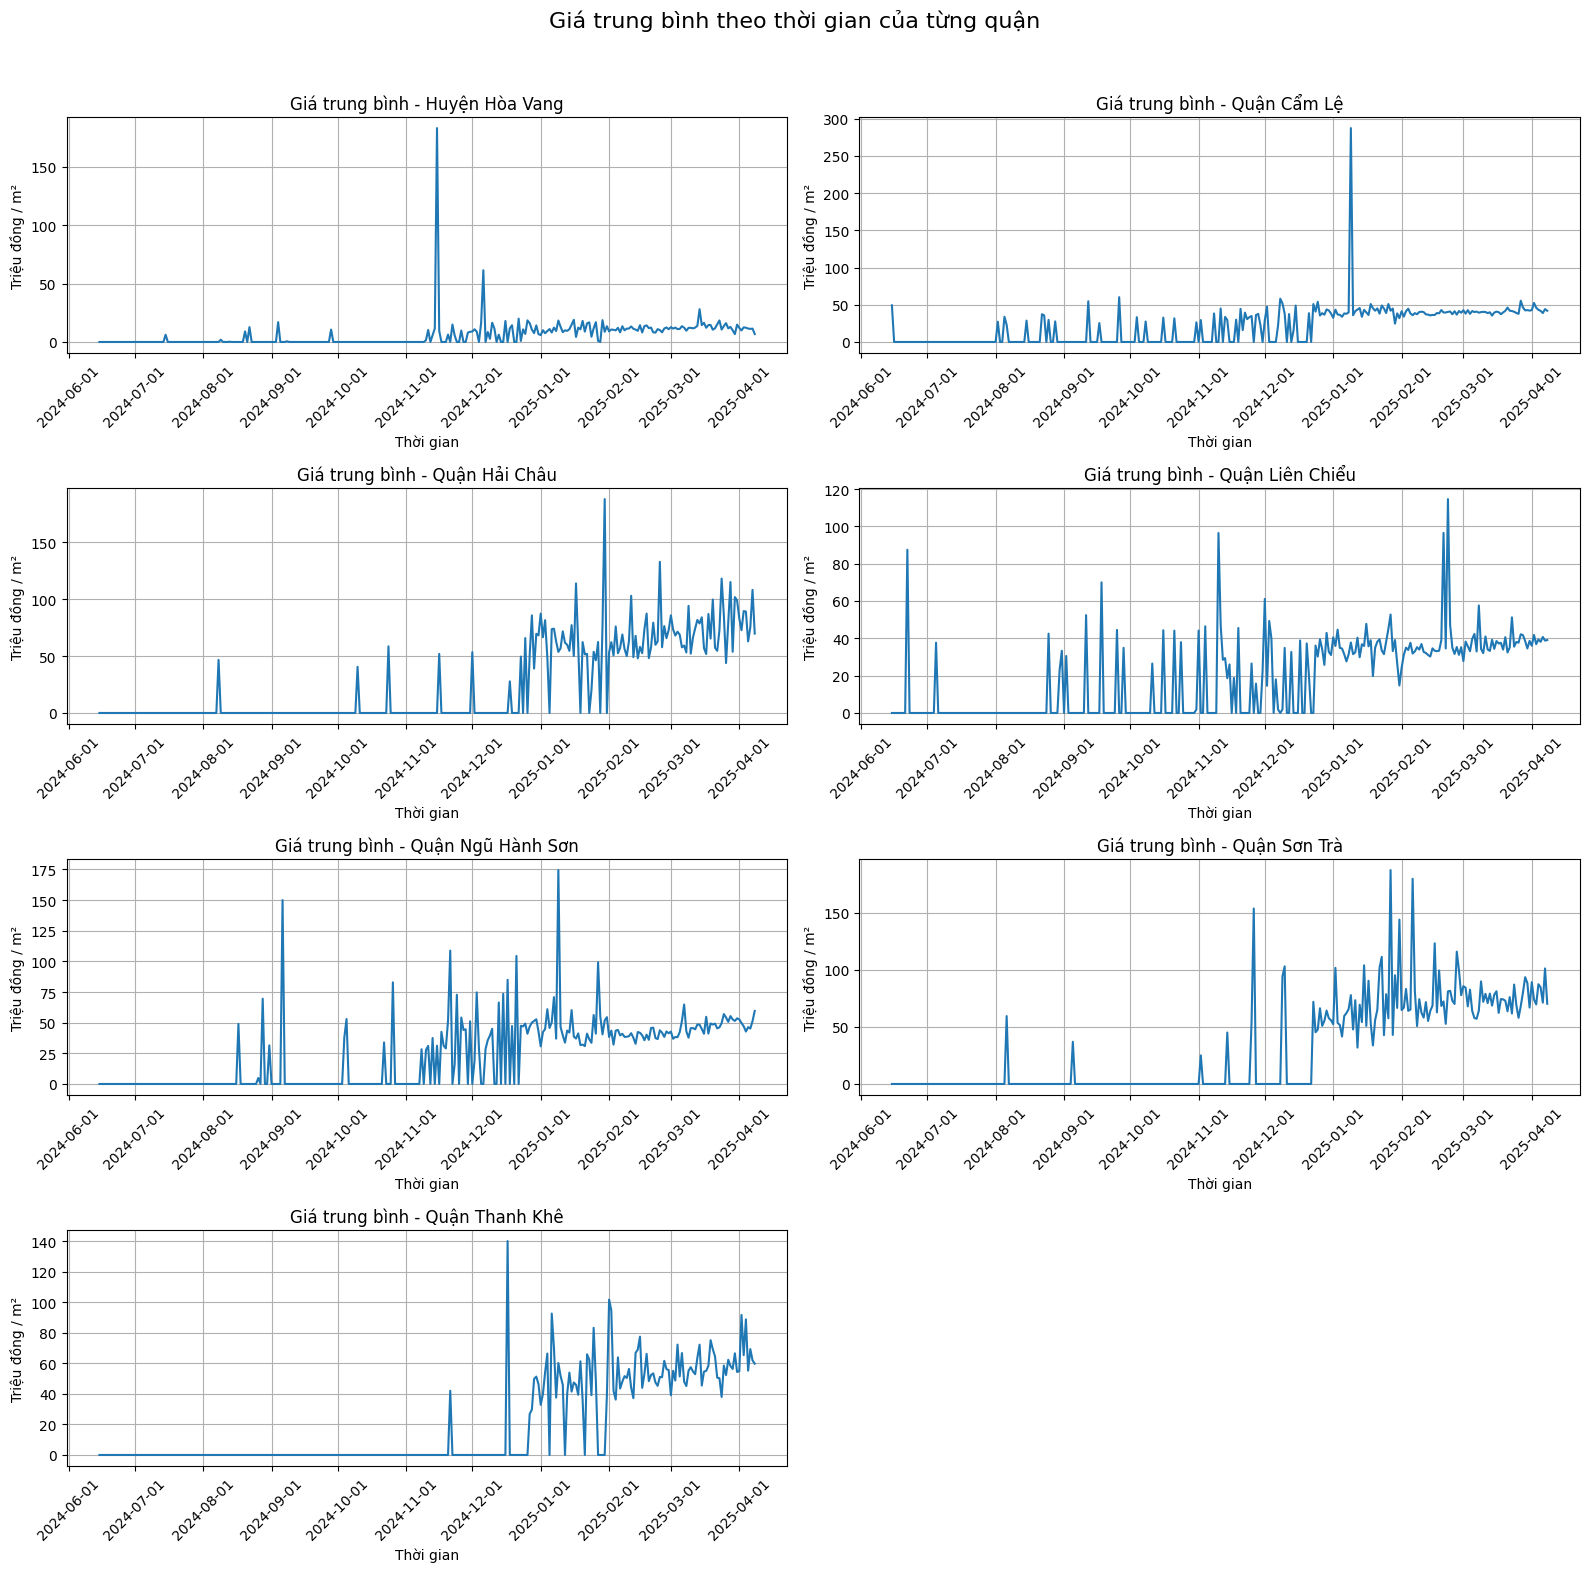

In [110]:
df_filled = fill_missing_days_with_zero(avg_price_district)
plot_avg_price_by_district(df_filled)

In [111]:
# Lọc dữ liệu từ sau tháng 12/2024
df_filled = df_filled[df_filled["Posted Time"] >= "2024-12-01"]
df_filled["Posted Time"] = pd.to_datetime(df_filled["Posted Time"])

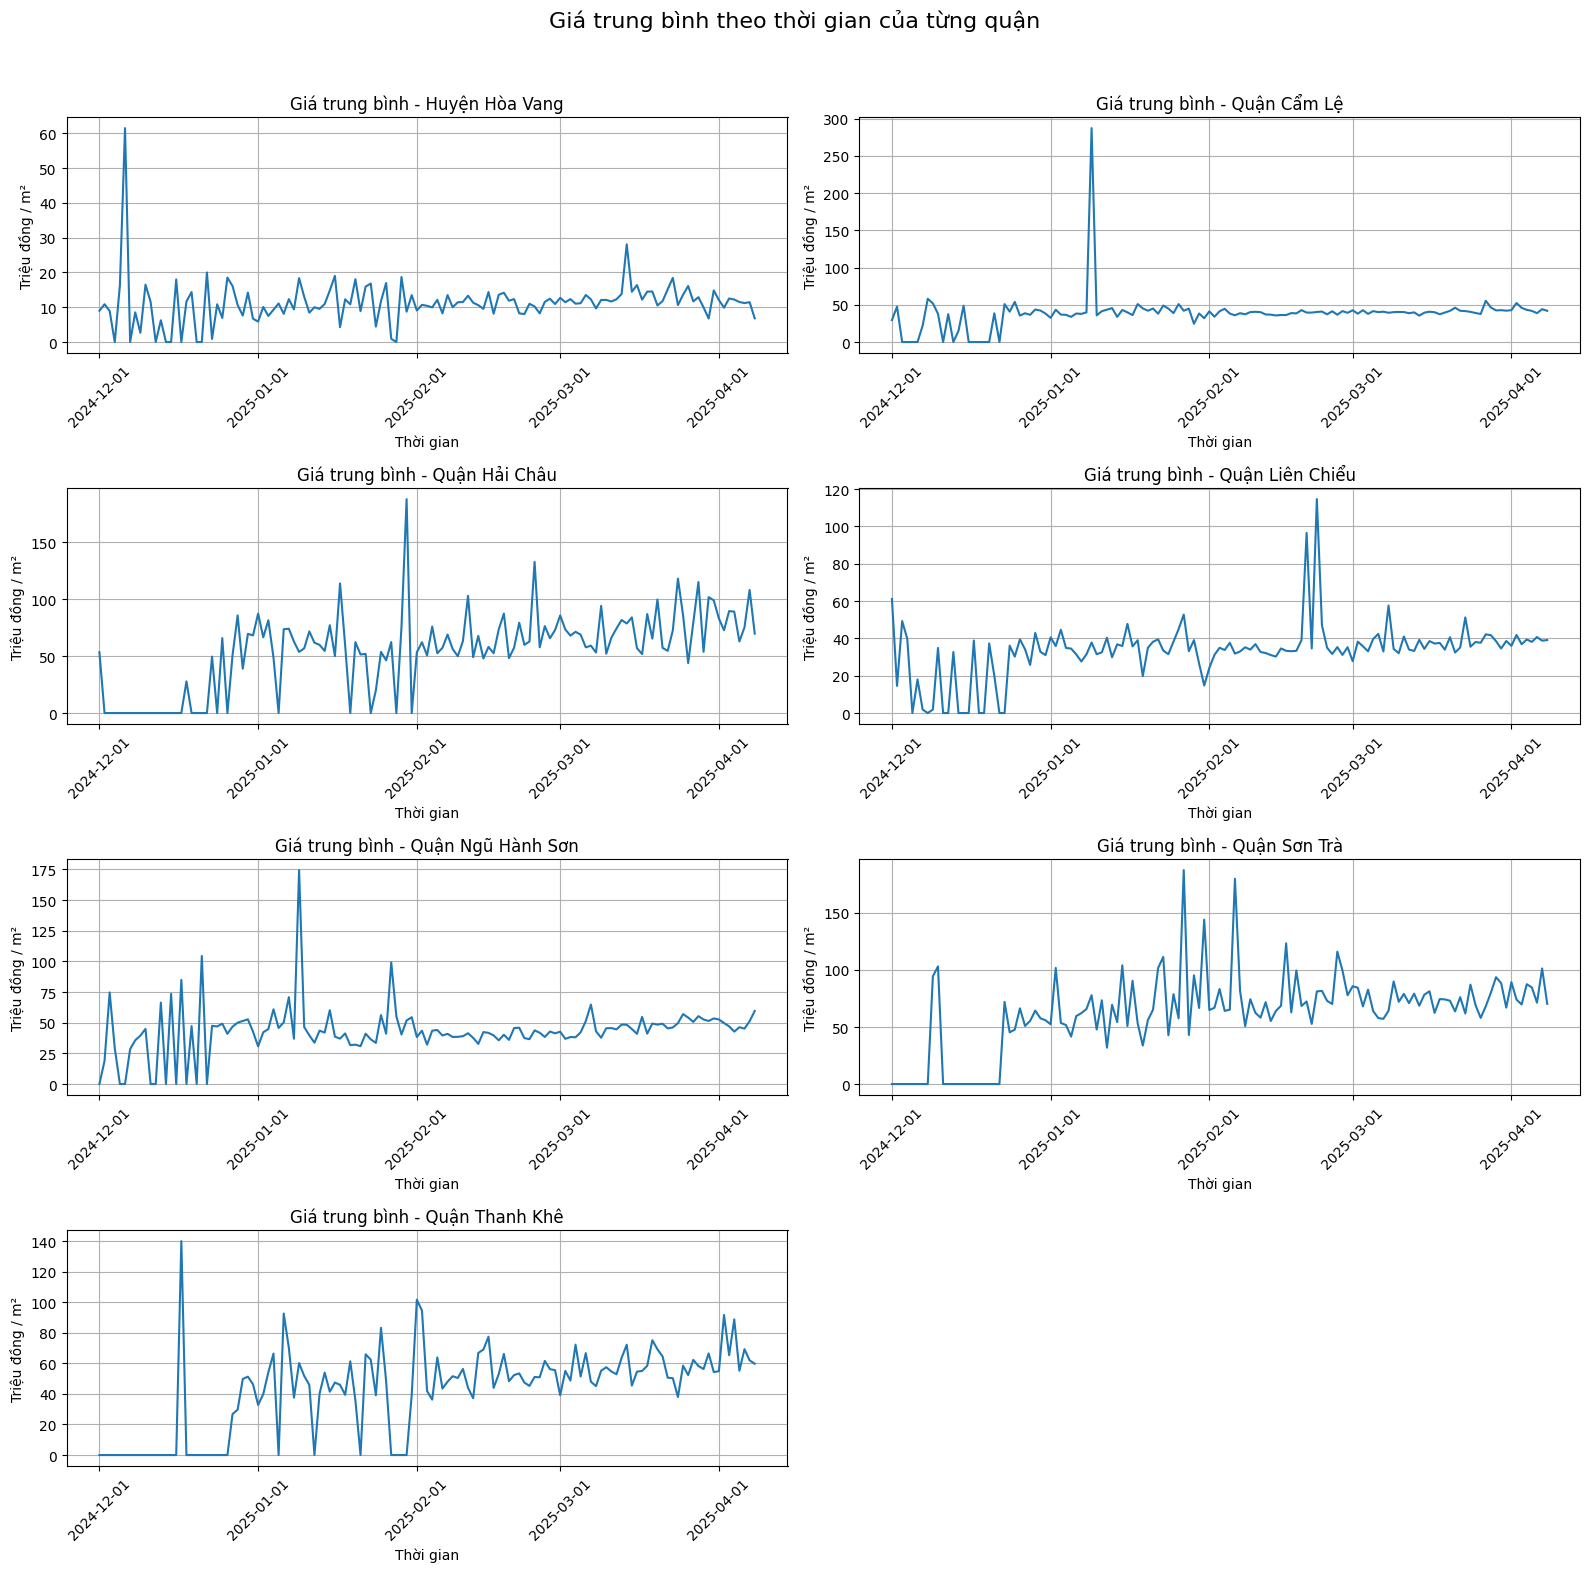

In [112]:
plot_avg_price_by_district(df_filled)

In [113]:
def fill_zero_with_progressive_mean(df_filled: pd.DataFrame) -> pd.DataFrame:
    df_result = []

    for district, group in df_filled.groupby("District Name"):
        df = group.sort_values("Posted Time").copy()
        prices = df["Price per m2"].values

        # Lấy giá trị trung bình của tất cả giá trị khác 0
        non_zero_mean = df[df["Price per m2"] > 0]["Price per m2"].mean()

        for i in range(len(prices)):
            if prices[i] == 0:
                # Nếu là phần tử đầu tiên
                if i == 0:
                    prices[i] = non_zero_mean
                else:
                    # Giá trị trước đó đã được cập nhật
                    prev = prices[i - 1] if prices[i - 1] > 0 else None
                    # Tìm giá trị sau đó khác 0
                    next_ = next((prices[j] for j in range(i + 1, len(prices)) if prices[j] > 0), None)

                    if prev is not None and next_ is not None:
                        prices[i] = (prev + next_) / 2
                    elif prev is not None:
                        prices[i] = prev
                    elif next_ is not None:
                        prices[i] = next_
                    else:
                        prices[i] = non_zero_mean

        df["Price per m2"] = prices
        df_result.append(df)

    return pd.concat(df_result, ignore_index=True)


In [114]:
df_cleaned = fill_zero_with_progressive_mean(df_filled)

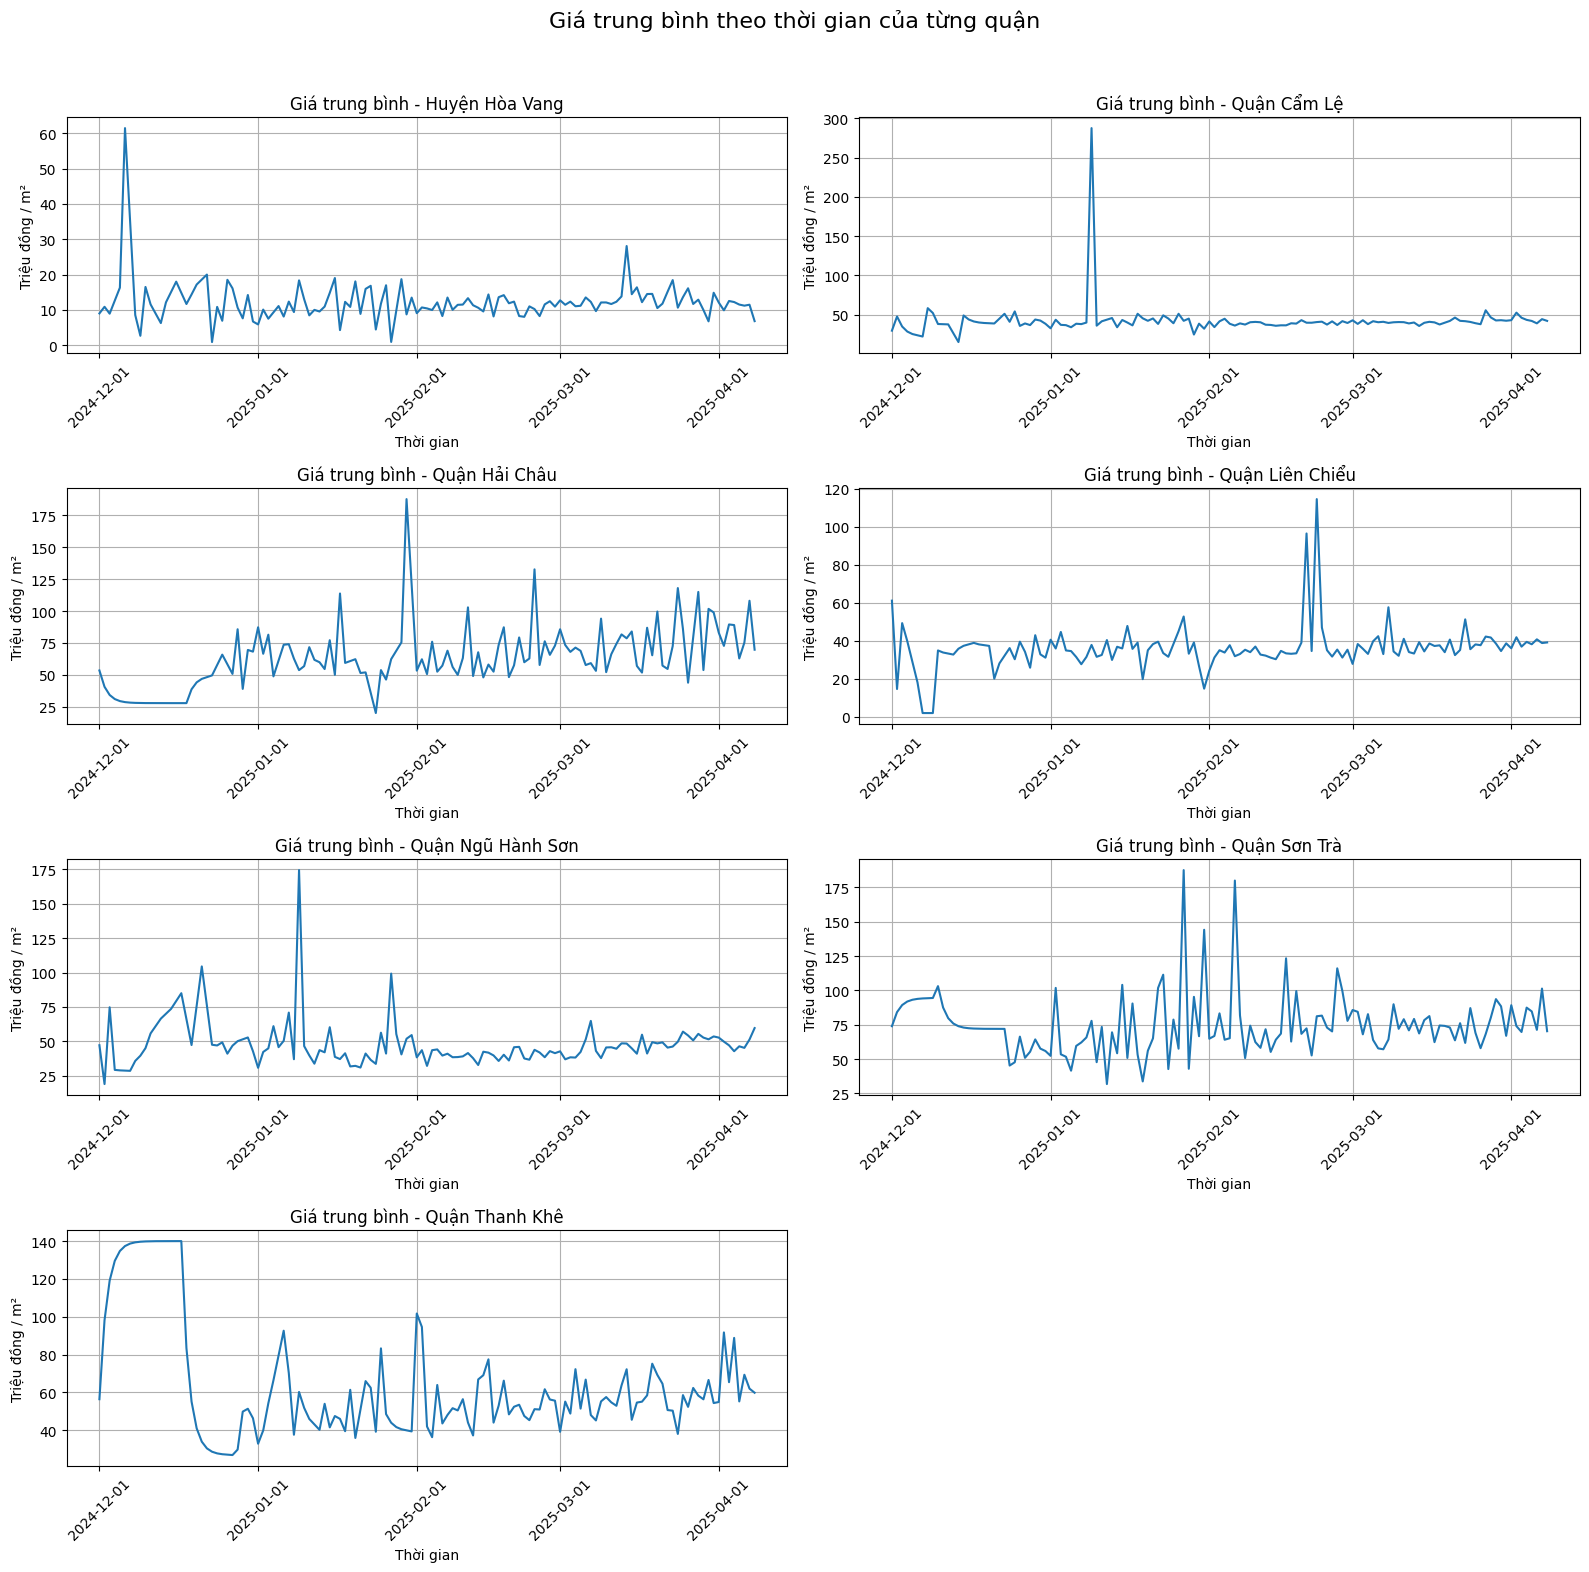

In [115]:
plot_avg_price_by_district(df_cleaned)

In [116]:
def smooth_all_by_district(df: pd.DataFrame, window_size: int = 7) -> pd.DataFrame:
    df = df.copy()
    df["Posted Time"] = pd.to_datetime(df["Posted Time"])
    all_results = []

    for district, group in df.groupby("District Name"):
        group = group.sort_values("Posted Time").copy()

        # Áp dụng trung bình trượt toàn bộ quận
        group["Smoothed Price"] = (
            group["Price per m2"]
            .rolling(window=window_size, center=True)
            .mean()
            .fillna(method="ffill")
            .fillna(method="bfill")
        )

        all_results.append(group)

    df_result = pd.concat(all_results).sort_values(["District Name", "Posted Time"])
    return df_result


In [117]:
def plot_smoothed_price_by_district(df_smoothed: pd.DataFrame):
    districts = df_smoothed["District Name"].unique()
    ncols = 2
    nrows = math.ceil(len(districts) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
    axes = axes.flatten()

    for i, district in enumerate(districts):
        ax = axes[i]
        df_district = df_smoothed[df_smoothed["District Name"] == district]

        ax.plot(df_district["Posted Time"], df_district["Price per m2"], label="Original", alpha=0.4)
        ax.plot(df_district["Posted Time"], df_district["Smoothed Price"], label="Smoothed", color="red")

        ax.set_title(f"Giảm nhiễu - {district}")
        ax.set_xlabel("Thời gian")
        ax.set_ylabel("Triệu đồng / m²")
        ax.grid(True)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.tick_params(axis="x", rotation=45)
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Giảm nhiễu theo quận", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

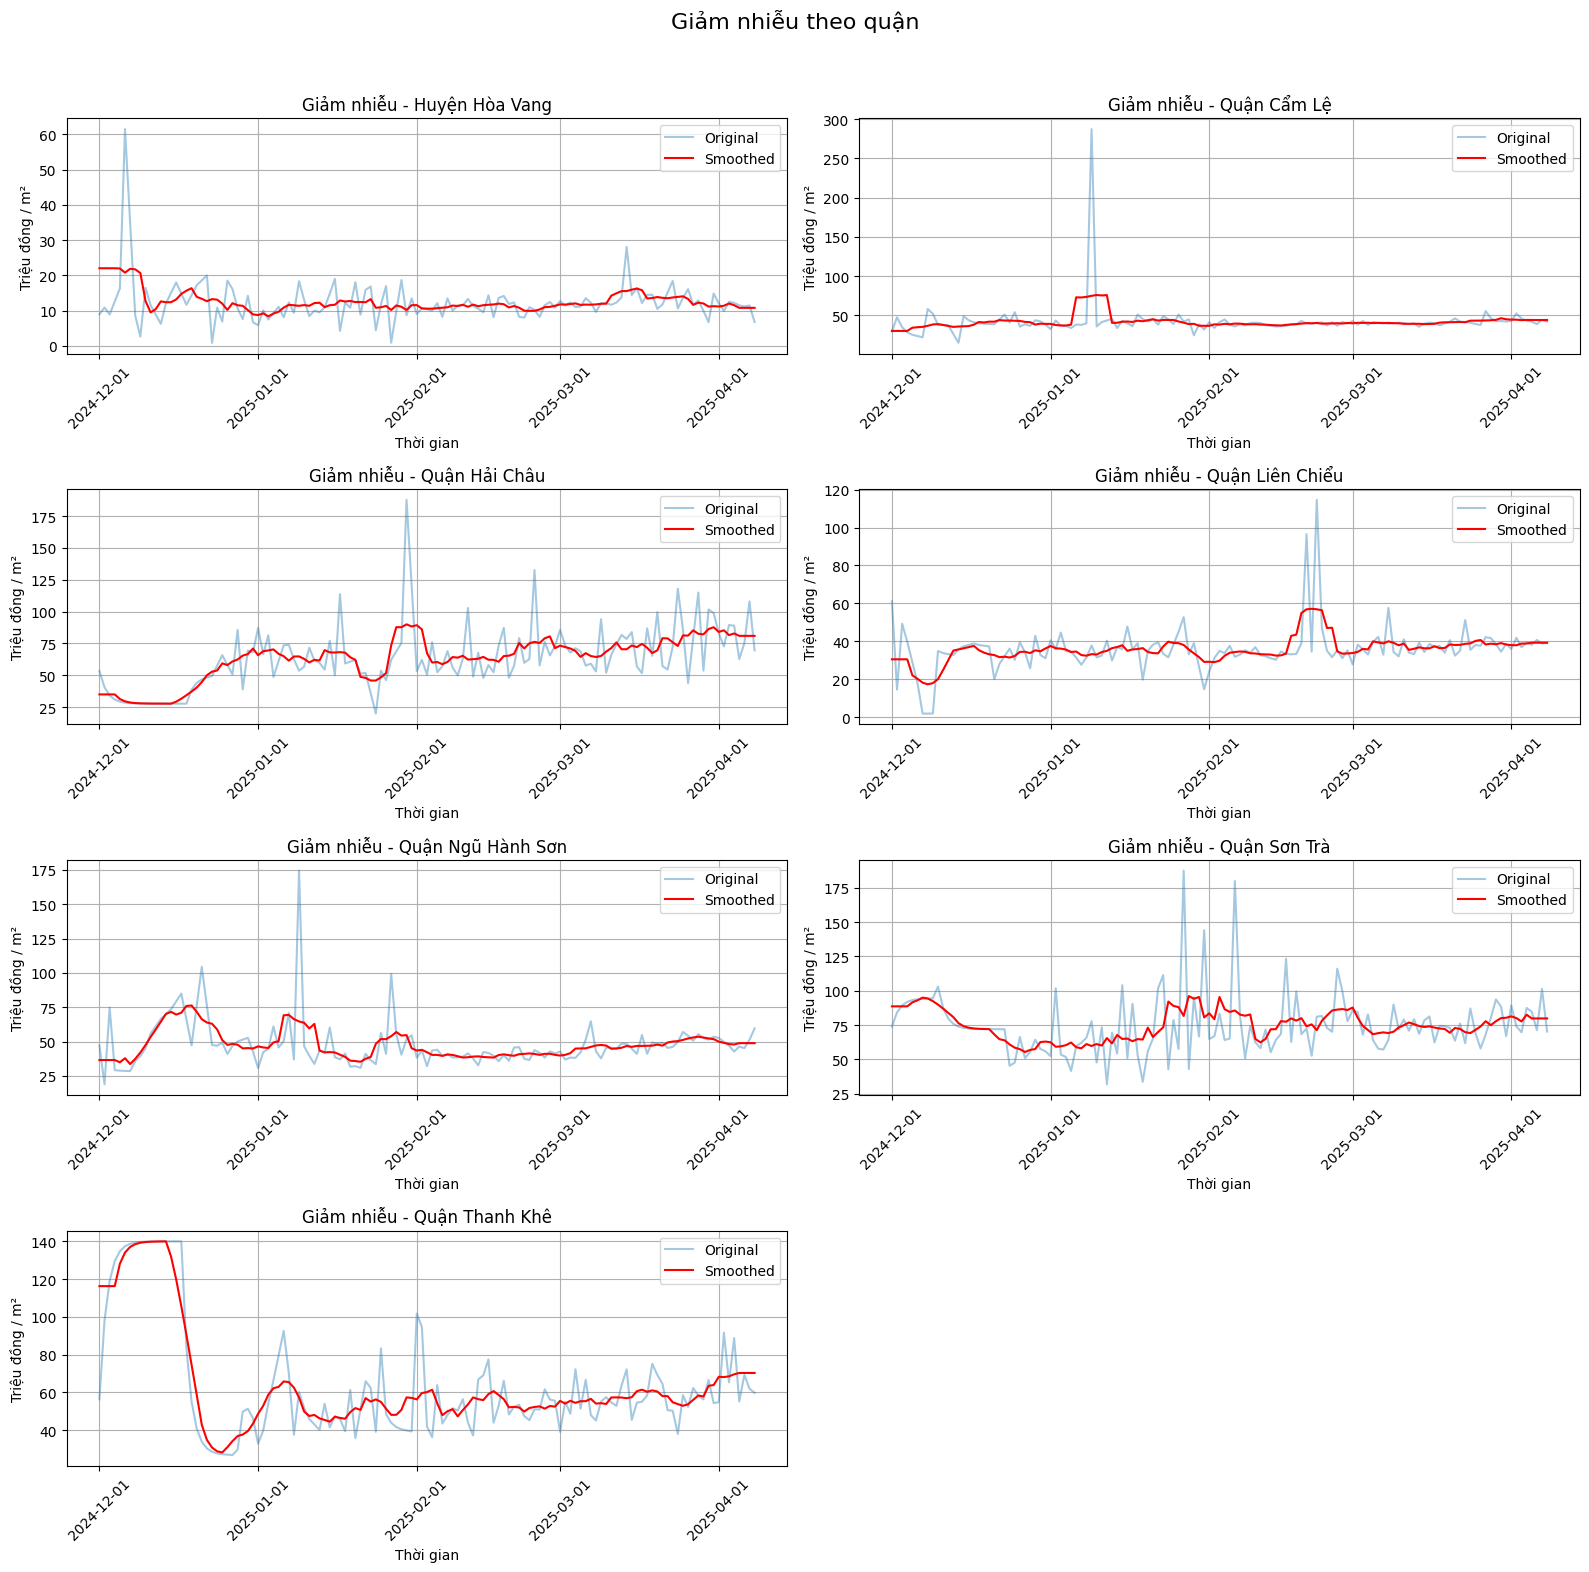

In [118]:
df_smoothed = smooth_all_by_district(df_cleaned, 7)
plot_smoothed_price_by_district(df_smoothed)

In [119]:
print(df_smoothed["Smoothed Price"].isna().sum())
nan_rows = df_smoothed[df_smoothed["Smoothed Price"].isna()]
print(nan_rows[["Posted Time", "Smoothed Price"]])

0
Empty DataFrame
Columns: [Posted Time, Smoothed Price]
Index: []


In [120]:
df_smoothed = df_smoothed.drop(columns=["Price per m2"])
df_smoothed = df_smoothed.rename(columns={"Smoothed Price": "Price per m2"})

## Feature Transformation

### Normalization using Z-score method

In [121]:
columns_to_minmax = ["Price per m2"]
minmax_scaler = MinMaxScaler()
df_minmax_scaled = minmax_scaler.fit_transform(df_smoothed[columns_to_minmax])
df_minmax_scaled = pd.DataFrame(df_minmax_scaled, columns=columns_to_minmax)

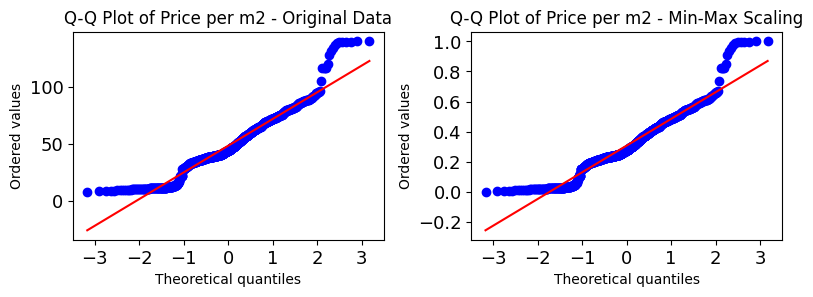

In [122]:
dfs = [df_smoothed, df_minmax_scaled]
methods = ["Original Data", "Min-Max Scaling"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i)
    stats.probplot(data["Price per m2"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Price per m2 - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.tight_layout()

plt.show()

In [123]:
df_final = df_smoothed.copy()
df_final["Price per m2"] = df_minmax_scaled["Price per m2"].values

df_final.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,0.103732
1,2024-12-02,Huyện Hòa Vang,0.103732
2,2024-12-03,Huyện Hòa Vang,0.103732
3,2024-12-04,Huyện Hòa Vang,0.103732
4,2024-12-05,Huyện Hòa Vang,0.103227


In [124]:
# Create DataFrame for statistics
mins = minmax_scaler.data_min_
maxs = minmax_scaler.data_max_

# Tạo DataFrame lưu min-max
scaler_stats = {
    'Metric': ['min', 'max'],
    'price': [mins[0], maxs[0]]
}

# Thư mục mới để lưu file
output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

df_minmax_stats = pd.DataFrame(scaler_stats)
df_minmax_stats.to_csv('predict_scaler_params.csv', index=False)

# Lưu file vào thư mục mới
output_path = os.path.join(output_dir, 'predict_scaler_params.csv')
df_minmax_stats.to_csv(output_path, index=False)

print("File 'predict_scaler_params.csv' has been successfully created!")


File 'predict_scaler_params.csv' has been successfully created!


In [125]:
df_final.to_csv('TransformedData.csv', index=False)
print("DataFrame exported to CSV file.")

DataFrame exported to CSV file.


# General conclusion